In [3]:
import pandas as pd
import numpy as np

# Set seed for reproducibility
np.random.seed(42)

# Jumlah sampel yang diinginkan
n_samples = 7000

# Generate fitur X dengan skala 0–4
data = {
    "Emosi_Mudah_Tersinggung": np.random.randint(0, 5, n_samples),
    "Fisik_Susah_Tidur": np.random.randint(0, 5, n_samples),
    "Pikiran_Tidak_Kontrol": np.random.randint(0, 5, n_samples),
    "GayaHidup_Olahraga": np.random.randint(0, 5, n_samples),
    "Sosial_Dukungan": np.random.randint(0, 5, n_samples),
}

# Hitung total skor
df = pd.DataFrame(data)
df["Total_Skor"] = df.sum(axis=1)

# Fungsi untuk mengklasifikasikan tingkat stres
def klasifikasi_stres(skor):
    if skor <= 4:
        return 0  # Sangat Rendah
    elif skor <= 8:
        return 1  # Rendah
    elif skor <= 12:
        return 2  # Sedang
    elif skor <= 16:
        return 3  # Tinggi
    else:
        return 4  # Sangat Tinggi

# Tambahkan kolom target
df["Tingkat_Stres"] = df["Total_Skor"].apply(klasifikasi_stres)

# Hapus kolom Total_Skor jika tidak diperlukan
df = df.drop(columns=["Total_Skor"])

In [5]:
# Coba simpan ulang ke direktori saat ini jika /mnt/data tidak tersedia
csv_path = "data_klasifikasi_stres_7000.csv"
df.to_csv(csv_path, index=False)

csv_path

'data_klasifikasi_stres_7000.csv'

In [6]:
df1 = pd.read_csv('/content/data_klasifikasi_stres_7000.csv')

df1.head()

,Emosi_Mudah_Tersinggung,Fisik_Susah_Tidur,Pikiran_Tidak_Kontrol,GayaHidup_Olahraga,Sosial_Dukungan,Tingkat_Stres
0,3,4,0,2,4,3
1,4,1,3,3,2,3
2,2,4,4,4,2,3
3,4,0,1,3,1,2
4,4,1,2,0,3,2


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [02:32:22] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


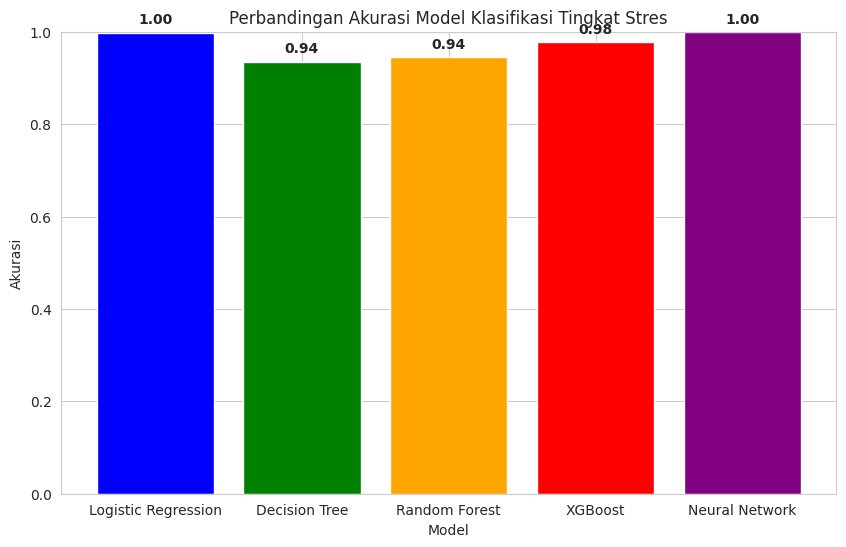

In [10]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, accuracy_score
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.utils import to_categorical

# --- Load Dataset ---
df = pd.read_csv("data_klasifikasi_stres_7000.csv")

# --- Pisahkan fitur dan target ---
X = df.drop("Tingkat_Stres", axis=1)
y = df["Tingkat_Stres"]

# --- Standarisasi fitur ---
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# --- Split data ---
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

# --- Dictionary untuk menyimpan hasil evaluasi ---
results = {}
accuracies = {}

# --- Model 1: Logistic Regression ---
lr = LogisticRegression(max_iter=200)
lr.fit(X_train, y_train)
y_pred_lr = lr.predict(X_test)
results['Logistic Regression'] = classification_report(y_test, y_pred_lr, output_dict=True)
accuracies['Logistic Regression'] = accuracy_score(y_test, y_pred_lr)

# --- Model 2: Decision Tree ---
dt = DecisionTreeClassifier(random_state=42)
dt.fit(X_train, y_train)
y_pred_dt = dt.predict(X_test)
results['Decision Tree'] = classification_report(y_test, y_pred_dt, output_dict=True)
accuracies['Decision Tree'] = accuracy_score(y_test, y_pred_dt)

# --- Model 3: Random Forest ---
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)
y_pred_rf = rf.predict(X_test)
results['Random Forest'] = classification_report(y_test, y_pred_rf, output_dict=True)
accuracies['Random Forest'] = accuracy_score(y_test, y_pred_rf)

# --- Model 4: XGBoost ---
xgb = XGBClassifier(use_label_encoder=False, eval_metric='mlogloss', random_state=42)
xgb.fit(X_train, y_train)
y_pred_xgb = xgb.predict(X_test)
results['XGBoost'] = classification_report(y_test, y_pred_xgb, output_dict=True)
accuracies['XGBoost'] = accuracy_score(y_test, y_pred_xgb)

# --- Model 5: Neural Network ---
num_classes = len(y.unique())
y_train_cat = to_categorical(y_train, num_classes=num_classes)
y_test_cat = to_categorical(y_test, num_classes=num_classes)

nn = Sequential([
    Dense(64, activation='relu', input_shape=(X_train.shape[1],)),
    Dense(32, activation='relu'),
    Dense(num_classes, activation='softmax')
])
nn.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
nn.fit(X_train, y_train_cat, epochs=10, batch_size=32, verbose=0)
nn_eval = nn.evaluate(X_test, y_test_cat, verbose=0)
results['Neural Network'] = {"accuracy": nn_eval[1]}
accuracies['Neural Network'] = nn_eval[1]

# --- Visualisasi Perbandingan Akurasi ---
plt.figure(figsize=(10,6))
plt.bar(accuracies.keys(), accuracies.values(), color=['blue', 'green', 'orange', 'red', 'purple'])
plt.ylim(0,1)
plt.title("Perbandingan Akurasi Model Klasifikasi Tingkat Stres")
plt.ylabel("Akurasi")
plt.xlabel("Model")
for i, v in enumerate(accuracies.values()):
    plt.text(i, v + 0.02, f"{v:.2f}", ha='center', fontweight='bold')
plt.show()


<ipython-input-11-8b86b533349d>:18: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  barplot = sns.barplot(data=acc_df, x='Model', y='Akurasi', palette='viridis')


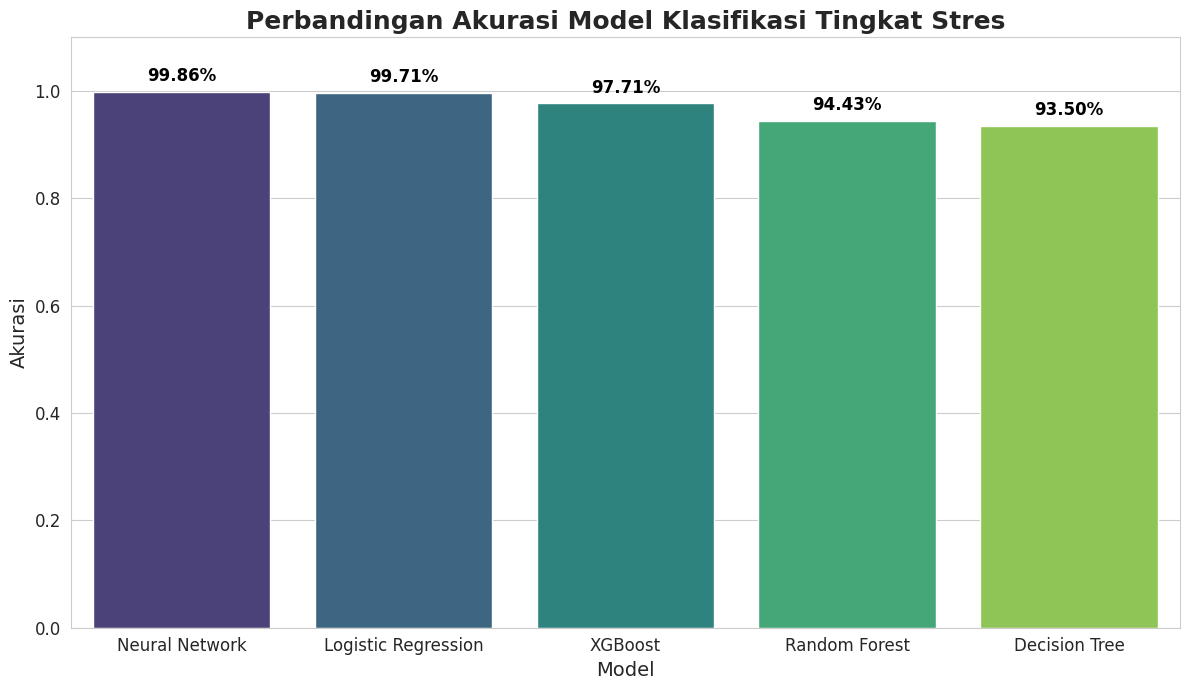

In [11]:
import seaborn as sns
import matplotlib.pyplot as plt

# --- Visualisasi Perbandingan Akurasi yang Lebih Menarik ---
plt.figure(figsize=(12,7))
sns.set_style("whitegrid")

# Buat DataFrame dari dictionary akurasi agar mudah pakai seaborn
acc_df = pd.DataFrame({
    'Model': list(accuracies.keys()),
    'Akurasi': list(accuracies.values())
})

# Urutkan berdasarkan akurasi descending supaya lebih rapi
acc_df = acc_df.sort_values(by='Akurasi', ascending=False)

# Barplot dengan palet warna 'viridis' untuk gradasi warna yang smooth
barplot = sns.barplot(data=acc_df, x='Model', y='Akurasi', palette='viridis')

# Tambahkan anotasi nilai akurasi di atas bar
for i, (model, acc) in enumerate(zip(acc_df['Model'], acc_df['Akurasi'])):
    barplot.text(i, acc + 0.02, f"{acc:.2%}", ha='center', fontweight='bold', fontsize=12, color='black')

# Styling tambahan
plt.ylim(0, 1.1)
plt.title("Perbandingan Akurasi Model Klasifikasi Tingkat Stres", fontsize=18, fontweight='bold')
plt.ylabel("Akurasi", fontsize=14)
plt.xlabel("Model", fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.tight_layout()
plt.show()
